In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [3]:
random.seed(42)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('mode.use_inf_as_na', True)
df_raw =  pd.read_csv("SO_ML_2022.csv", skiprows=1)
df_raw.isnull().sum()

FileNotFoundError: [Errno 2] No such file or directory: 'SO_ML_2022.csv'

## Data Cleaning

- O7_O6_ratio: ratio of Oxygen atoms with 7 missing elections (+7) and Oxygen atoms with 6 missing electrons (+6)
    - ratio cannot be negative so need to remove rows where this is negative

- C6_C4_ratio: ratio of +6 carbon to +4 carbon
    - ratio cannot be negative

- C6_C5_ratio: ratio of +6 carbon to +5 carbon
    - ratio cannot be negative

- Fe_O_ratio: Ratio of iron to oxygen
    - ratio cannot be negative

- O_ave_charge: average charge of oxygen atoms
    - cannot be over 8 because oxygen only has 8 electrons to lose

- velocity: velocity of particles in solar wind
    - should be around a few hundred, need to remove higher or lower

- density: particle density of solar wind
    - should be from 0-a few hundred

In [ ]:
# remove rows with negative ratios
df = df_raw[df_raw['O7_O6_ratio'] >= 0]
df = df[df['C6_C4_ratio'] >= 0]
df = df[df['C6_C5_ratio'] >= 0]
df = df[df['Fe_O_ratio'] >= 0]
# remove rows where O_ave_charge is greater than 8
df = df[df['O_ave_charge'] < 8]
# remove rows with nan as a velocity
df.dropna(inplace=True)
df.to_csv('SO_ML_2022_cleaned.csv')

In [ ]:
df = pd.read_csv('SO_ML_2022_cleaned.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,fractional_year,O7_O6_ratio,C6_C4_ratio,C6_C5_ratio,Fe_O_ratio,O_ave_charge,velocity,density
0,2022.049316,0.089865,2.458390,0.444265,0.150213,6.074951,494.797,2.82344
1,2022.049335,0.083158,2.841864,0.410422,0.160867,6.072842,489.727,2.96590
2,2022.049354,0.098469,2.527932,0.328493,0.132257,6.086165,491.465,2.65348
3,2022.049373,0.070984,2.794871,0.356665,0.135882,6.060820,490.259,2.89073
4,2022.049392,0.078036,1.416381,0.329367,0.154701,6.068972,493.497,2.96546


## Exploratory Data Analysis

### Correlation

In [ ]:
df_corr = df[].corr()
df_corr

,fractional_year,O7_O6_ratio,C6_C4_ratio,C6_C5_ratio,Fe_O_ratio,O_ave_charge,velocity,density
fractional_year,1.000000,-0.091760,-0.113547,-0.109207,-0.023825,-0.026817,0.019199,0.104320
O7_O6_ratio,-0.091760,1.000000,0.539937,0.552404,0.264880,0.914527,-0.491470,0.171348
C6_C4_ratio,-0.113547,0.539937,1.000000,0.773682,-0.038401,0.495198,-0.474612,-0.000416
C6_C5_ratio,-0.109207,0.552404,0.773682,1.000000,-0.056638,0.506321,-0.524439,0.005065
Fe_O_ratio,-0.023825,0.264880,-0.038401,-0.056638,1.000000,0.193546,-0.066951,0.232137
O_ave_charge,-0.026817,0.914527,0.495198,0.506321,0.193546,1.000000,-0.496352,0.174769
velocity,0.019199,-0.491470,-0.474612,-0.524439,-0.066951,-0.496352,1.000000,-0.287008
density,0.104320,0.171348,-0.000416,0.005065,0.232137,0.174769,-0.287008,1.000000


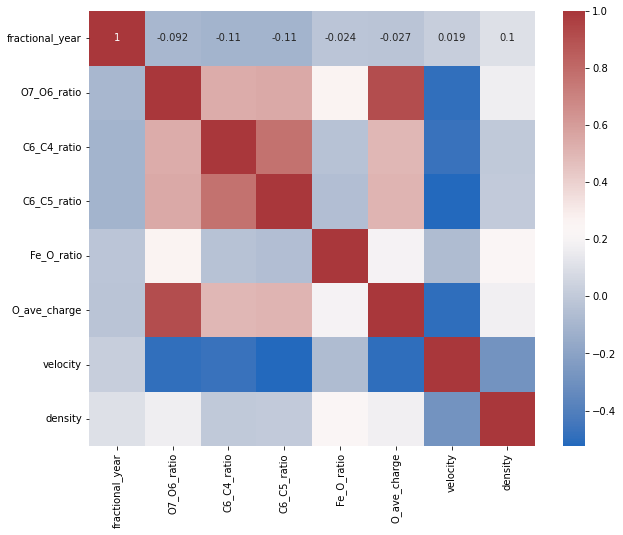

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap="vlag")
plt.savefig('corr_heatmap.png')

### PCA

In [ ]:
df['mass_flow_rate'] = df['velocity']*df['density']

[0.58088877 0.2245757  0.14770843 0.02904497 0.00796445 0.00492492
 0.00303323 0.00185953]


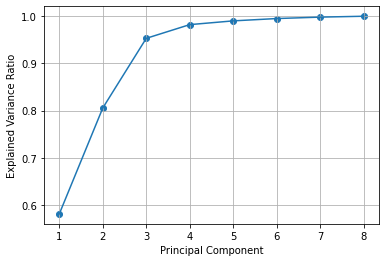

In [ ]:
# scale the data using min/max scaler
cols = df.columns.tolist()[1:]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[cols])
pca = PCA()
pca.fit(data_scaled)
print(pca.explained_variance_ratio_)
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.scatter(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.grid()
plt.show()

In [ ]:
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_scaled)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca.to_csv('pca_3components.csv')

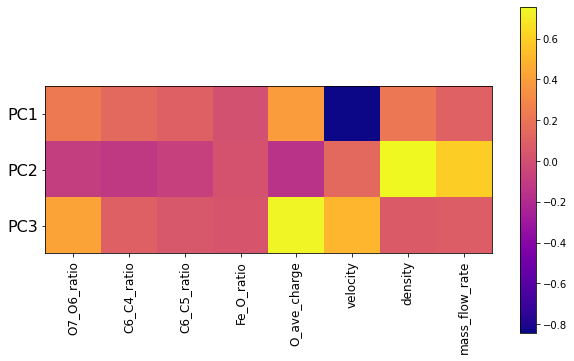

In [ ]:
def plot_cancer_pca(pca, df, cols, top_k=3):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca.components_[0:top_k], interpolation="none", cmap="plasma")
    feature_names = list(df[cols].columns)
    plt.xticks(
        np.arange(-0.0, len(feature_names), 1), feature_names, rotation=90, fontsize=12
    )
    plt.yticks(np.arange(0.0, top_k, 1), [f"PC{i+1}" for i in range(top_k)], fontsize=16)
    plt.colorbar()

plot_cancer_pca(pca, df, cols)

### Clustering

Optimal number of clusters: 2
Best silhouette score: 0.4584269248571126
Silhouette score: 0.46


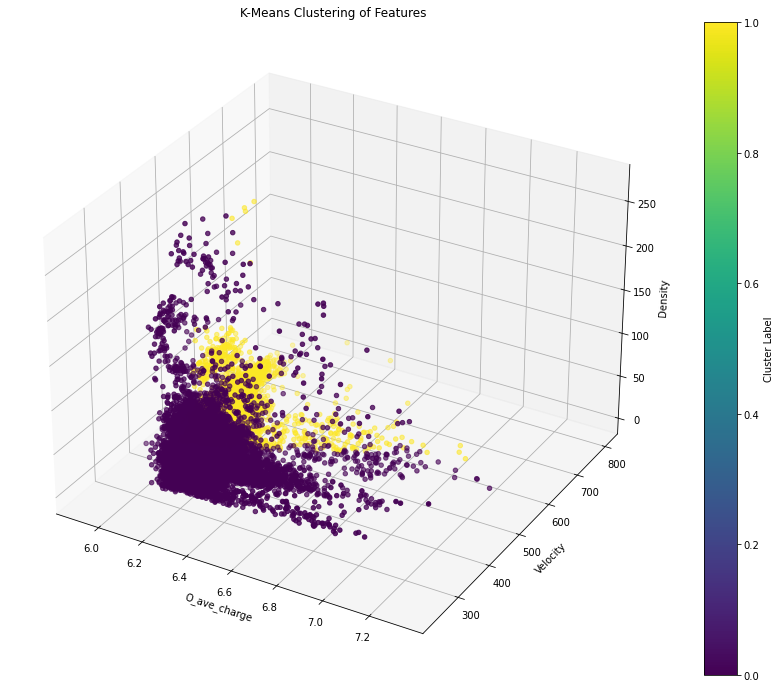

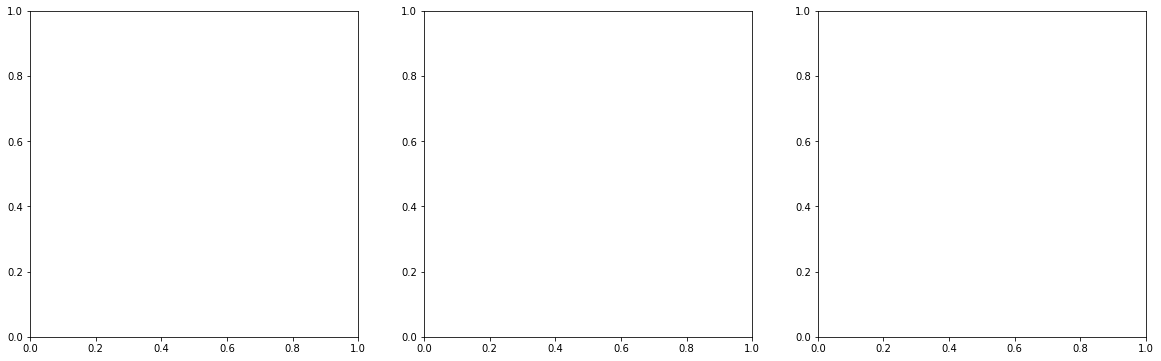

In [ ]:
features = ['O_ave_charge', 'velocity', 'density']
X = df[features].values

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# K range
num_clusters_range = range(2, 11)

best_score = -1
best_num_clusters = 0

# Perform grid search
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Calculate silhouette score
    score = silhouette_score(X_scaled, labels)
    if score > best_score:
        best_score = score
        best_num_clusters = num_clusters

print(f"Optimal number of clusters: {best_num_clusters}")
print(f"Best silhouette score: {best_score}")

# Train the final model with the best number of clusters
kmeans = KMeans(n_clusters=best_num_clusters, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Calculate silhouette score for the final model
silhouette = silhouette_score(X_scaled, labels)
print(f"Silhouette score: {silhouette:.2f}")


centers = kmeans.cluster_centers_
X_original = scaler.inverse_transform(X_scaled)

# Visualize the clustering results in 3D
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_original[:, 0], X_original[:, 1], X_original[:, 2], c=labels, cmap='viridis')
ax.set_xlabel('O_ave_charge')
ax.set_ylabel('Velocity')
ax.set_zlabel('Density')
ax.set_title('K-Means Clustering of Features')
plt.colorbar(sc, ax=ax, label='Cluster Label')
plt.savefig('kmeans_clustering_3d.png')
plt.show()

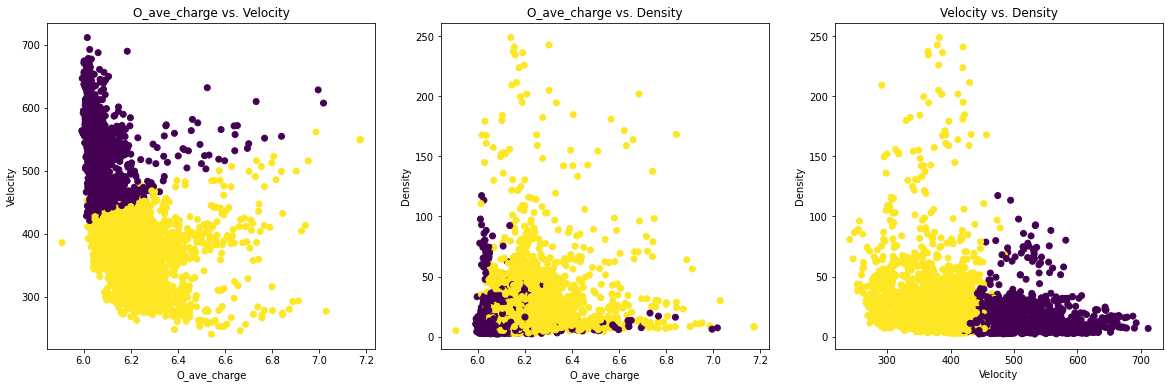

In [ ]:
# Visualize the clustering results in 2D pairs
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# O_ave_charge vs. Velocity
axes[0].scatter(X_test_original[:, 0], X_test_original[:, 1], c=test_labels, cmap='viridis')
axes[0].set_xlabel('O_ave_charge')
axes[0].set_ylabel('Velocity')
axes[0].set_title('O_ave_charge vs. Velocity')

# O_ave_charge vs. Density
axes[1].scatter(X_test_original[:, 0], X_test_original[:, 2], c=test_labels, cmap='viridis')
axes[1].set_xlabel('O_ave_charge')
axes[1].set_ylabel('Density')
axes[1].set_title('O_ave_charge vs. Density')

# Velocity vs. Density
axes[2].scatter(X_test_original[:, 1], X_test_original[:, 2], c=test_labels, cmap='viridis')
axes[2].set_xlabel('Velocity')
axes[2].set_ylabel('Density')
axes[2].set_title('Velocity vs. Density')

plt.savefig('kmeans_clustering_2d_pairs.png')
plt.show()

In [ ]:
# Define the grid of parameters
epsilon_values = np.arange(0.1, 0.8, 0.05)
min_samples_values = range(4, 8)

best_score = -1
best_params = {}

# Perform grid search
for epsilon in epsilon_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        # Only calculate silhouette score if there are more than one cluster
        if len(set(labels)) > 1:
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_score = score
                best_params = {'epsilon': epsilon, 'min_samples': min_samples}

print(f"Optimal parameters: {best_params}")
print(f"Best silhouette score: {best_score}")

# Train the final model with the best parameters
dbscan = DBSCAN(eps=best_params['epsilon'], min_samples=best_params['min_samples'])
labels = dbscan.fit_predict(X_scaled)

# Only calculate silhouette score if there are more than one cluster
if len(set(labels)) > 1:
    silhouette = silhouette_score(X_scaled, labels)
    print(f"Silhouette score: {silhouette:.2f}")
else:
    print("only one cluster, no score can be calculated.")


Optimal parameters: {'epsilon': 0.15000000000000002, 'min_samples': 6}
Best silhouette score: 0.6614085802904625
Silhouette score: 0.66


In [ ]:
# Identify the outliers (those labeled as -1)
outliers = np.where(labels == -1)[0]
print(f"Outliers indices: {outliers}")
outliers_df = df.iloc[outliers]
print("Outliers in DataFrame:\n", outliers_df)

Outliers indices: [ 4886  4887  4888  4889  4890  4891  5262  8341 11587]
Outliers in DataFrame:
        fractional_year  O7_O6_ratio  C6_C4_ratio  C6_C5_ratio  Fe_O_ratio  \
4886       2022.191520     0.065376     0.335491     0.420907    0.583797   
4887       2022.191539     0.069325     0.347119     0.309816    0.482645   
4888       2022.191558     0.070624     0.469798     0.470597    0.663712   
4889       2022.191577     0.064931     0.357504     0.459226    0.731158   
4890       2022.191596     0.076451     0.490220     0.462570    0.576223   
4891       2022.191615     0.101641     0.857302     0.542979    0.326554   
5262       2022.272361     1.387374    10.794540     1.002587    0.055514   
8341       2022.436174     2.588494     1.604762     2.092765    1.277093   
11587      2022.666343     0.959086     1.001405     0.804367    8.980139   

       O_ave_charge  velocity    density  mass_flow_rate  
4886       6.036970   589.175  183.34200   108020.522850  
4887       6.

In [ ]:
outliers_df

,fractional_year,O7_O6_ratio,C6_C4_ratio,C6_C5_ratio,Fe_O_ratio,O_ave_charge,velocity,density,mass_flow_rate
4886,2022.191520,0.065376,0.335491,0.420907,0.583797,6.036970,589.175,183.34200,108020.522850
4887,2022.191539,0.069325,0.347119,0.309816,0.482645,6.045261,568.395,217.92200,123865.775190
4888,2022.191558,0.070624,0.469798,0.470597,0.663712,6.045951,608.449,214.27900,130377.843271
4889,2022.191577,0.064931,0.357504,0.459226,0.731158,6.035228,612.568,216.38100,132548.076408
4890,2022.191596,0.076451,0.490220,0.462570,0.576223,6.054009,629.786,219.81100,138433.890446
4891,2022.191615,0.101641,0.857302,0.542979,0.326554,6.080357,598.563,160.97300,96352.481799
5262,2022.272361,1.387374,10.794540,1.002587,0.055514,7.323942,278.842,85.72340,23903.284303
8341,2022.436174,2.588494,1.604762,2.092765,1.277093,6.438046,802.017,8.39854,6735.771855
11587,2022.666343,0.959086,1.001405,0.804367,8.980139,6.230808,803.652,14.10490,11335.431095


In [ ]:
set(labels)

{-1, 0}

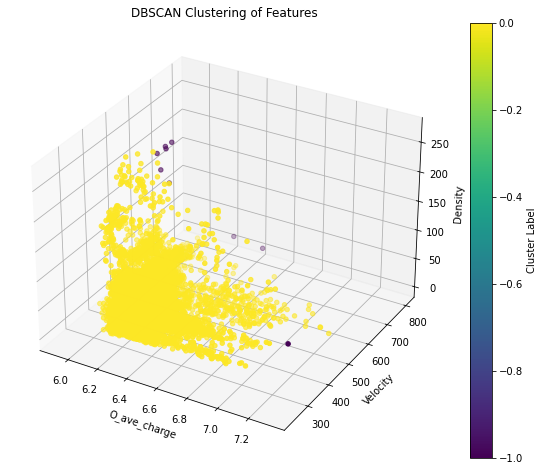

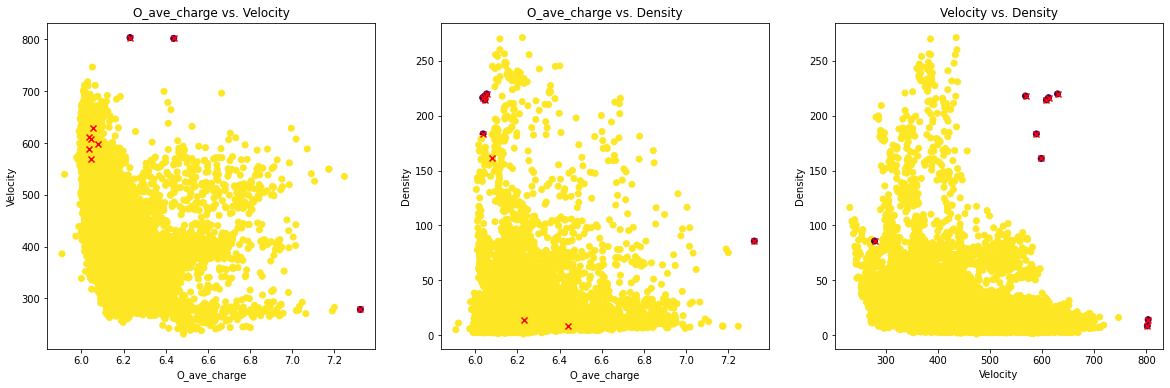

In [ ]:
X_original = scaler.inverse_transform(X_scaled)

# Visualize the clustering results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_original[:, 0], X_original[:, 1], X_original[:, 2], c=labels, cmap='viridis')
ax.set_xlabel('O_ave_charge')
ax.set_ylabel('Velocity')
ax.set_zlabel('Density')
ax.set_title('DBSCAN Clustering of Features')
plt.colorbar(sc, ax=ax, label='Cluster Label')
plt.savefig('dbscan_clustering_3d.png')
plt.show()

# Visualize the clustering results in 2D pairs
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# O_ave_charge vs. Velocity
axes[0].scatter(X_original[:, 0], X_original[:, 1], c=labels, cmap='viridis', label='Cluster')
axes[0].scatter(X_original[outliers, 0], X_original[outliers, 1], c='red', label='Outliers', marker='x')
axes[0].set_xlabel('O_ave_charge')
axes[0].set_ylabel('Velocity')
axes[0].set_title('O_ave_charge vs. Velocity')

# O_ave_charge vs. Density
axes[1].scatter(X_original[:, 0], X_original[:, 2], c=labels, cmap='viridis', label='Cluster')
axes[1].scatter(X_original[outliers, 0], X_original[outliers, 2], c='red', label='Outliers', marker='x')
axes[1].set_xlabel('O_ave_charge')
axes[1].set_ylabel('Density')
axes[1].set_title('O_ave_charge vs. Density')

# Velocity vs. Density
axes[2].scatter(X_original[:, 1], X_original[:, 2], c=labels, cmap='viridis', label='Cluster')
axes[2].scatter(X_original[outliers, 1], X_original[outliers, 2], c='red', label='Outliers', marker='x')
axes[2].set_xlabel('Velocity')
axes[2].set_ylabel('Density')
axes[2].set_title('Velocity vs. Density')

# Save the combined plot
plt.savefig('dbscan_clustering_2d_pairs.png')

# Show the plot
plt.show()

### Isolation Forest

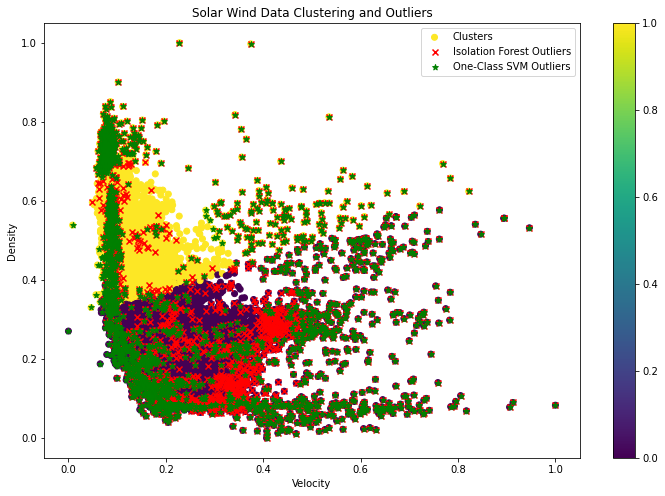

In [ ]:
features = ['O_ave_charge', 'velocity', 'density']
X = df[features].values

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

# Identify outliers using Isolation Forest
isolation_forest = IsolationForest(contamination='auto')
outlier_scores = isolation_forest.fit_predict(X_scaled)

# Identify outliers using One-Class SVM
ocsvm = OneClassSVM(nu=0.1)
ocsvm.fit(X_scaled)
ocsvm_scores = ocsvm.decision_function(X_scaled)

# Combine
df['cluster'] = kmeans.labels_
df['isolation_forest_score'] = outlier_scores
df['ocsvm_score'] = ocsvm_scores


# Visualize the clusters and outliers
plt.figure(figsize=(12, 8))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df['cluster'], cmap='viridis', label='Clusters')
plt.scatter(X_scaled[df['isolation_forest_score'] == -1, 0], X_scaled[df['isolation_forest_score'] == -1, 1], c='r', marker='x', label='Isolation Forest Outliers')
plt.scatter(X_scaled[df['ocsvm_score'] < 0, 0], X_scaled[df['ocsvm_score'] < 0, 1], c='g', marker='*', label='One-Class SVM Outliers')
plt.title('Solar Wind Data Clustering and Outliers')
plt.xlabel('Velocity')
plt.ylabel('Density')
plt.legend()
plt.colorbar()
plt.savefig('isolation_svm.png')
plt.show()


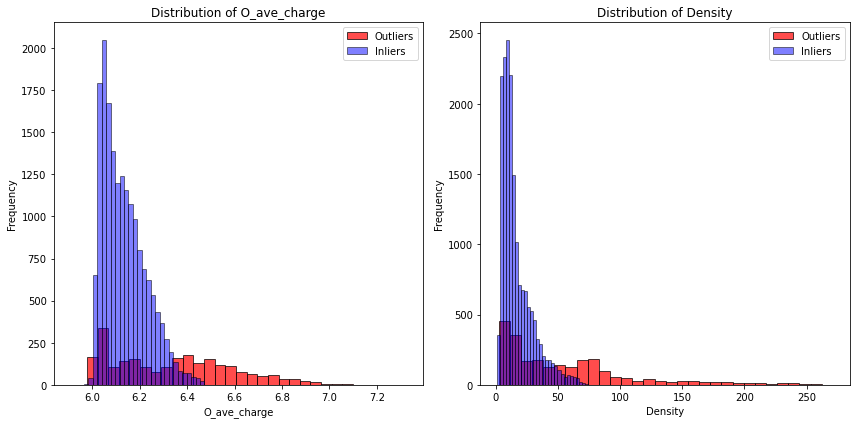

In [ ]:
# Compare features of outliers vs. inliers
outliers_df = df[df['isolation_forest_score'] == -1]
inliers_df = df[df['isolation_forest_score'] == 1]

# Compare specific features (e.g., 'O_ave_charge' and 'density')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(outliers_df['O_ave_charge'], bins=30, edgecolor='k', alpha=0.7, color='r', label='Outliers')
plt.hist(inliers_df['O_ave_charge'], bins=30, edgecolor='k', alpha=0.5, color='b', label='Inliers')
plt.title('Distribution of O_ave_charge')
plt.xlabel('O_ave_charge')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(outliers_df['density'], bins=30, edgecolor='k', alpha=0.7, color='r', label='Outliers')
plt.hist(inliers_df['density'], bins=30, edgecolor='k', alpha=0.5, color='b', label='Inliers')
plt.title('Distribution of Density')
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.savefig('ouliter_distribution_pairs.png')
plt.show()


* Outlier scores are typically negative values. The more negative the score, the more anomalous or outlying the data point is. Scores close to zero indicate that the point is closer to the decision boundary between normal and outlier.

* Positive scores are often not considered in the context of outlier detection, as they usually represent points deemed as normal.

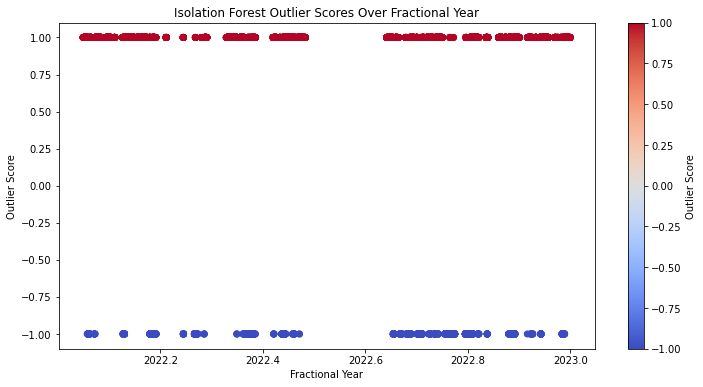

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(df['fractional_year'], df['isolation_forest_score'], c=df['isolation_forest_score'], cmap='coolwarm', label='Outlier Score')
plt.title('Isolation Forest Outlier Scores Over Fractional Year')
plt.xlabel('Fractional Year')
plt.ylabel('Outlier Score')
plt.colorbar(label='Outlier Score')
plt.savefig('outlier_score_year.png')
plt.show()

In [ ]:
cluster_means = df.groupby('cluster')[['O_ave_charge', 'density']].mean()

# Identify the cluster with the highest average 'O_ave_charge'
highest_charge_cluster = cluster_means['O_ave_charge'].idxmax()
highest_charge_value = cluster_means['O_ave_charge'].max()

# Identify the cluster with the lowest average 'density'
lowest_density_cluster = cluster_means['density'].idxmin()
lowest_density_value = cluster_means['density'].min()
print("\nCluster Averages:")
print(cluster_means)

Cluster with the highest average 'O_ave_charge': Cluster 0 with an average charge of 6.23
Cluster with the lowest average 'density': Cluster 1 with an average density of 13.46

Cluster Averages:
         O_ave_charge    density
cluster                         
0            6.227717  27.976047
1            6.075404  13.463511


# LSTM forecast

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
torch.manual_seed(42)

In [ ]:
df_lstm = pd.read_csv('SO_ML_2022_cleaned.csv').drop(columns=['Unnamed: 0'])
df_lstm['mass_flow_rate'] = df_lstm['velocity']*df_lstm['density']
df_lstm.head()

,fractional_year,O7_O6_ratio,C6_C4_ratio,C6_C5_ratio,Fe_O_ratio,O_ave_charge,velocity,density,mass_flow_rate
0,2022.049316,0.089865,2.458390,0.444265,0.150213,6.074951,494.797,2.82344,1397.029642
1,2022.049335,0.083158,2.841864,0.410422,0.160867,6.072842,489.727,2.96590,1452.481309
2,2022.049354,0.098469,2.527932,0.328493,0.132257,6.086165,491.465,2.65348,1304.092548
3,2022.049373,0.070984,2.794871,0.356665,0.135882,6.060820,490.259,2.89073,1417.206399
4,2022.049392,0.078036,1.416381,0.329367,0.154701,6.068972,493.497,2.96546,1463.445614


In [ ]:
feature_columns = ['fractional_year', 'C6_C4_ratio', 'C6_C5_ratio', 'Fe_O_ratio', 'velocity', 'density', 'mass_flow_rate']
target_columns = ['O7_O6_ratio', 'O_ave_charge']

# Separate features and targets
X = df_lstm[feature_columns]
y = df_lstm[target_columns]

# Initialize MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the features and targets
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Convert scaled data to DataFrames
X_scaled = pd.DataFrame(X_scaled, columns=feature_columns)
y_scaled = pd.DataFrame(y_scaled, columns=target_columns)

# Perform the train-test split without shuffling
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=False)

# Convert DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.4):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, states=None):
        if states is None:
            batch_size = x.size(0)
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            states = (h0, c0)

        out, (h_out, c_out) = self.lstm(x, states)
        out = self.fc(out[:, -1, :])

        return out, (h_out, c_out)

In [ ]:
# Parameters
input_size = X_train.shape[1]  # Number of features
hidden_size = 64
num_layers = 2
output_size = y_train.shape[1]  # Number of output variables
num_epochs = 1000
learning_rate = 0.005

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop
train_losses = []
val_losses = []

patience = 100
best_val_loss = float('inf')
early_stop_counter = 0

In [ ]:
for epoch in range(num_epochs):
    model.train()
    outputs, _ = model(X_train_tensor.unsqueeze(1))
    output_tensor = outputs
    loss = criterion(output_tensor, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs, _ = model(X_test_tensor.unsqueeze(1))
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

    if epoch == 0 or (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f'Early stopping triggered at epoch {epoch+1} with Validation Loss: {val_loss.item():.4f}')
        break

# Save model
torch.save(model.state_dict(), 'lstm_model.pth')

Epoch [1/1000], Train Loss: 0.0444, Val Loss: 0.0305
Epoch [100/1000], Train Loss: 0.0045, Val Loss: 0.0037
Epoch [200/1000], Train Loss: 0.0041, Val Loss: 0.0033
Epoch [300/1000], Train Loss: 0.0038, Val Loss: 0.0031
Epoch [400/1000], Train Loss: 0.0038, Val Loss: 0.0031
Epoch [500/1000], Train Loss: 0.0037, Val Loss: 0.0031
Epoch [600/1000], Train Loss: 0.0037, Val Loss: 0.0030
Epoch [700/1000], Train Loss: 0.0037, Val Loss: 0.0030
Epoch [800/1000], Train Loss: 0.0036, Val Loss: 0.0030
Epoch [900/1000], Train Loss: 0.0037, Val Loss: 0.0030
Epoch [1000/1000], Train Loss: 0.0036, Val Loss: 0.0030


Validation Loss: 0.0030


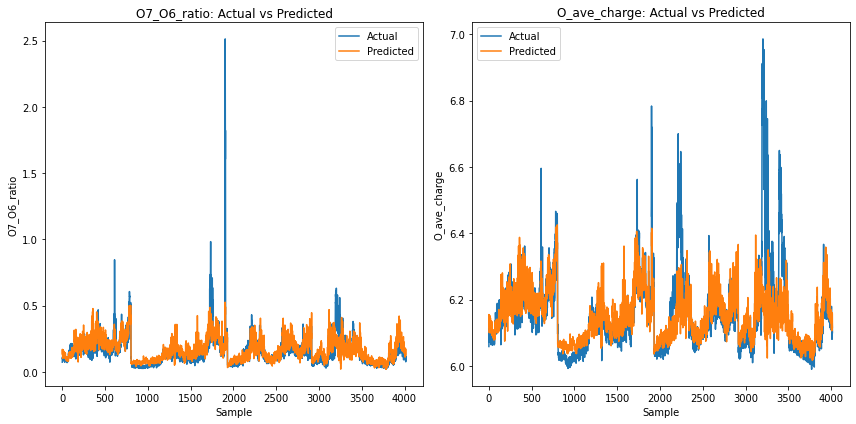

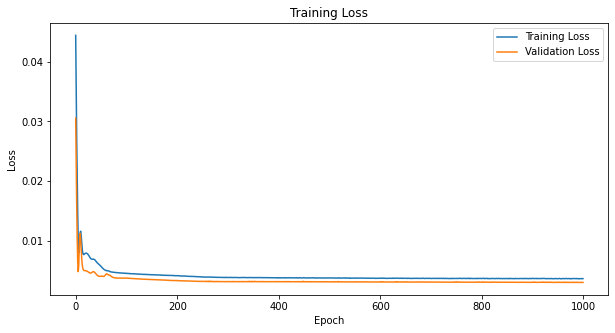

In [ ]:
# Evaluation on validation set
model.eval()
with torch.no_grad():
    val_outputs, _ = model(X_test_tensor.unsqueeze(1))
    val_loss = criterion(val_outputs, y_test_tensor)
    print(f'Validation Loss: {val_loss.item():.4f}')

# Inverse transform to get actual predicted values
y_test_pred = scaler_y.inverse_transform(val_outputs.numpy())
y_test_actual = scaler_y.inverse_transform(y_test)

# Visualize predictions vs actual
plt.figure(figsize=(12, 6))

# Plotting O7_O6_ratio
plt.subplot(1, 2, 1)
plt.plot(y_test_actual[:, 0], label='Actual')
plt.plot(y_test_pred[:, 0], label='Predicted')
plt.title('O7_O6_ratio: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('O7_O6_ratio')
plt.legend()

# Plotting O_ave_charge
plt.subplot(1, 2, 2)
plt.plot(y_test_actual[:, 1], label='Actual')
plt.plot(y_test_pred[:, 1], label='Predicted')
plt.title('O_ave_charge: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('O_ave_charge')
plt.legend()

plt.tight_layout()
plt.savefig('test_performance.png')
plt.show()

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


## Future trend prediction for 2024

In [ ]:
def add_noise_based_on_std(data, noise_level=0.01):
    """
    Add Gaussian noise to each feature in the dataset based on its standard deviation.

    Parameters:
    - data: pandas DataFrame containing the features
    - noise_level: fraction of the feature's standard deviation to use as the standard deviation of the Gaussian noise

    Returns:
    - DataFrame with added noise
    """

    noisy_data = data.copy()
    for column in noisy_data.columns:
        std_dev = noisy_data[column].std()
        noise = np.random.normal(0, noise_level * std_dev, noisy_data[column].shape)
        noisy_data[column] += noise
    return noisy_data

Original Data:
    fractional_year  O7_O6_ratio  C6_C4_ratio  C6_C5_ratio  Fe_O_ratio  \
0      2022.049316     0.089865     2.458390     0.444265    0.150213   
1      2022.049335     0.083158     2.841864     0.410422    0.160867   
2      2022.049354     0.098469     2.527932     0.328493    0.132257   
3      2022.049373     0.070984     2.794871     0.356665    0.135882   
4      2022.049392     0.078036     1.416381     0.329367    0.154701   

   O_ave_charge  velocity  density  mass_flow_rate  
0      6.074951   494.797  2.82344     1397.029642  
1      6.072842   489.727  2.96590     1452.481309  
2      6.086165   491.465  2.65348     1304.092548  
3      6.060820   490.259  2.89073     1417.206399  
4      6.068972   493.497  2.96546     1463.445614  

Noisy Data:
    fractional_year  O7_O6_ratio  C6_C4_ratio  C6_C5_ratio  Fe_O_ratio  \
0      2022.047048     0.089782     2.113920     0.422723    0.152413   
1      2022.032581     0.094083     2.396651     0.418779    0.1456

In [ ]:
df_predict = df_lstm.copy()
year = df_predict['fractional_year']

# Add noise to the features based on their standard deviation
noise_level = 0.01
noisy_data = add_noise_based_on_std(df_predict, noise_level)

df_predict = noisy_data.copy()
df_predict['fractional_year'] = year + 2
df_predict['mass_flow_rate'] = df_predict['velocity']*df_predict['density']
df_predict.head()

,fractional_year,O7_O6_ratio,C6_C4_ratio,C6_C5_ratio,Fe_O_ratio,O_ave_charge,velocity,density,mass_flow_rate
0,2024.049316,0.091715,2.402035,0.442678,0.150406,6.075516,495.296485,2.817173,1395.336084
1,2024.049335,0.081865,2.828845,0.407723,0.162173,6.074031,489.284228,3.143606,1538.116684
2,2024.049354,0.098716,2.477201,0.332227,0.132235,6.083896,491.219729,2.847083,1398.543411
3,2024.049373,0.072530,2.766365,0.356975,0.136584,6.061505,489.568785,3.109952,1522.535518
4,2024.049392,0.079622,1.359483,0.324173,0.154690,6.068370,494.698825,2.984381,1476.369937


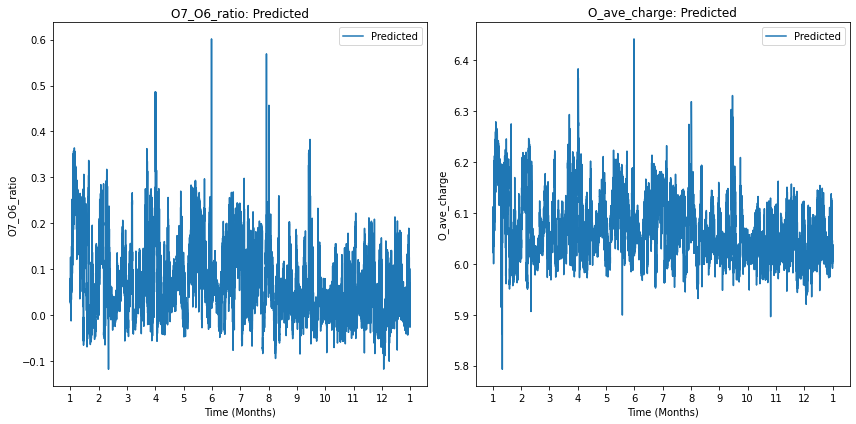

In [ ]:
feature_columns = ['fractional_year', 'C6_C4_ratio', 'C6_C5_ratio', 'Fe_O_ratio', 'velocity', 'density', 'mass_flow_rate']
target_columns = ['O7_O6_ratio', 'O_ave_charge']

# Separate features and targets
X_predict = df_predict[feature_columns]
X_predict_scaled = scaler_X.transform(X_predict)

# Convert to tensor
X_predict_tensor = torch.tensor(X_predict_scaled, dtype=torch.float32)

# Make predictions
model.eval()
with torch.no_grad():
    y_predict_tensor, _ = model(X_predict_tensor.unsqueeze(1))
    y_predict = scaler_y.inverse_transform(y_predict_tensor.numpy())

# Define number of months and the step size
num_samples = len(y_predict)
months_per_year = 12
steps_per_month = num_samples // months_per_year

# Generate tick positions and labels
time_ticks = np.arange(0, num_samples, steps_per_month)
tick_labels = np.tile(np.arange(1, months_per_year + 1), len(time_ticks) // months_per_year + 1)[:len(time_ticks)]

# Visualize predictions on a monthly scale
plt.figure(figsize=(12, 6))

# Plotting O7_O6_ratio
plt.subplot(1, 2, 1)
plt.plot(range(num_samples), y_predict[:, 0], label='Predicted')
plt.title('O7_O6_ratio: Predicted')
plt.xlabel('Time (Months)')
plt.ylabel('O7_O6_ratio')
plt.xticks(ticks=time_ticks, labels=tick_labels)  # Set x-ticks to display 1-12 for each year
plt.legend()

# Plotting O_ave_charge
plt.subplot(1, 2, 2)
plt.plot(range(num_samples), y_predict[:, 1], label='Predicted')
plt.title('O_ave_charge: Predicted')
plt.xlabel('Time (Months)')
plt.ylabel('O_ave_charge')
plt.xticks(ticks=time_ticks, labels=tick_labels)  # Set x-ticks to display 1-12 for each year
plt.legend()

plt.tight_layout()
plt.savefig('2024predict.png')
plt.show()